## Import Packages

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from ENID.interpolation import label_encoding
from ENID.DOClassify import network_train, network_evaluation

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

import random
random.seed(1)

## Import Data

In [2]:
# 3 Detections In Both Energy Bands
#datafile = 'Data/FluxNormalisedColourRatio1_3Detect/data_lc.npy'
#labelsfile = 'Data/FluxNormalisedColourRatio1_3Detect/labels.npy'

# 5 Detections In Both Energy Bands
#datafile = 'Data/FluxNormalisedColourRatio1_5Detect/data_lc.npy'
#labelsfile = 'Data/FluxNormalisedColourRatio1_5Detect/labels.npy'

# 5 Detections In Both Energy Bands, each band normalised w.r.t band maximum flux
datafile = 'Data/FluxNormalisedDouble/data_lc.npy'
labelsfile = 'Data/FluxNormalisedDouble/labels.npy'

data = np.load(datafile)
labels = np.load(labelsfile)

print('Data Dimensions :', data.shape)
print('Label Dimensions :', labels.shape)

Data Dimensions : (4428, 2, 200)
Label Dimensions : (4428, 2)


## Prepare for Training
### Output Information
Filenames are ordered as follows:

**ModelName_Modes_HU%%IT##**

ModelName : Information about the NN structure
- GRU : Gated Recurrent Unit
- GRUbi : Bi-directional Gated Recurrent Unit
- GRU2 : Two Gated Recurrent Units 

Modes : Information about training conditions
- Pen : Class penalty applied for under-represented classes

HU : Number of hidden units (given by %%)

IT : Iteration number of given model (given by ##)

### Partitioning and One-Hot Encoding 
We ignore the TDEs for the moment. These events are associated with a -1 label. 

We keep 10% of the entire data set as a test set to evaluate model generalisation after training. 

One-hot encoding is performed for the labels. 

In [3]:
# Standardise Data
#data = StandardScaler().fit_transform(data)
y = np.array([int(labels[i,1]) for i in range(labels.shape[0])])

# Filter out TDEs
idx = np.where(y >= 0)[0]
Y = torch.tensor(y[idx])
X = torch.permute(torch.tensor(data[idx]), [0,2,1])

# Check that the proportion of each class is roughly the same in the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
W = [1/count for count in np.unique(Y_train, return_counts=True)[1]]
W = W / min(W)
W = [int(element) for element in W]

print('Unique Labels :', np.unique(Y_train, return_counts=True)[0])
print('Training Label Proportions : ', np.unique(Y_train, return_counts=True)[1])
print('Test Label Proportions : ', np.unique(Y_test, return_counts=True)[1])
print('Estimated Class Weights : ', W, '\n')

# One-Hot Encoding
Y = label_encoding(Y).float()

# Final partitioning of the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print('Training Data Dimensions :', X_train.shape)
print('Training Label Dimensions :', Y_train.shape, '\n')

print('Test Data Dimensions :', X_test.shape)
print('Test Label Dimensions :', Y_test.shape, '\n')

Unique Labels : [0 1 2 3 4 5]
Training Label Proportions :  [ 119  719 2662   62  169  225]
Test Label Proportions :  [ 10  73 309  11  23  14]
Estimated Class Weights :  [22, 3, 1, 42, 15, 11] 

Training Data Dimensions : torch.Size([3956, 200, 2])
Training Label Dimensions : torch.Size([3956, 6]) 

Test Data Dimensions : torch.Size([440, 200, 2])
Test Label Dimensions : torch.Size([440, 6]) 



## Model Definition

### Model Class Definitions

In [6]:
class simple_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(simple_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=False) 
        self.Dense = nn.Linear(hidden_dim, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU(x)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_
    
class bi_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(bi_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True) 
        self.Dense = nn.Linear(2*hidden_dim, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU(x)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_
    
class rapid_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, n_layers):
        super(rapid_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU1 = nn.GRU(input_dim, hidden_dim1, n_layers, batch_first=True, bidirectional=False) 
        self.GRU2 = nn.GRU(hidden_dim1, hidden_dim2, n_layers, batch_first=True, bidirectional=False) 
        self.Dropout = nn.Dropout(p=0.2)
        self.Dense = nn.Linear(hidden_dim2, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU1(x)
        x_ = self.Dropout(x_)
        x_, h_ = self.GRU2(x_)
        x_ = self.Dropout(x_)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_

class sexy_ENID(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, conv_out1, conv_out2, kernel1, kernel2):
        super(sexy_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.channels1 = conv_out1
        self.channels2 = conv_out2
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.conv1_out = 200 - 2*(self.kernel1 - 1)
        self.conv2_out = self.conv1_out - 2 * (self.kernel2 - 1)
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=False) 
        
        self.Conv1 = nn.Conv1d(in_channels=2, out_channels=conv_out1, kernel_size=kernel1)
        self.Conv2 = nn.Conv1d(in_channels=conv_out1, out_channels=conv_out2, kernel_size=kernel2)
        self.Dense1_conv = nn.Linear(190, hidden_dim)
        #self.Dense2_conv = nn.Linear(out1_conv, out2_conv)
        self.relu = nn.ReLU()
        
        #self.DenseGRU = nn.Linear(hidden_dim, out_GRU)
        
        self.Dense = nn.Linear(2*hidden_dim, output_dim)
        self.Dropout = nn.Dropout(p=0.2)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        x_GRU, h_ = self.GRU(x)
        x_GRU = self.Dropout(x_GRU)
        #x_GRU = self.Dense(x_GRU[:,-1])
        
        x_ = torch.permute(x, (0,2,1))
        x_conv = self.Conv1(x_)
        x_conv = self.relu(x_conv)
        x_conv = self.Conv2(x_conv)
        x_conv = self.relu(x_conv)
        x_conv = self.Dropout(x_conv)
        x_conv = self.Dense1_conv(x_conv)
        x_conv = self.Dropout(x_conv)
        
        x_ENID = torch.cat((x_GRU, x_conv), dim=2)
        
        x_ENID = self.Dense(x_ENID[:,-1])
        x_ENID = self.predict(x_ENID)
        
        return x_ENID

### Model Training

#### GRU32 + Convolution

sexy_ENID(
  (GRU): GRU(2, 32, batch_first=True)
  (Conv1): Conv1d(2, 100, kernel_size=(9,), stride=(1,))
  (Conv2): Conv1d(100, 200, kernel_size=(3,), stride=(1,))
  (Dense1_conv): Linear(in_features=190, out_features=32, bias=True)
  (relu): ReLU()
  (Dense): Linear(in_features=64, out_features=6, bias=True)
  (Dropout): Dropout(p=0.2, inplace=False)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 6.80605

Training time: 26.538883209228516
Train Loss : 6.731767116054412
Test Loss : 5.536580562591553
Global Accuracy : 55.0%
F1 Measure : 0.54


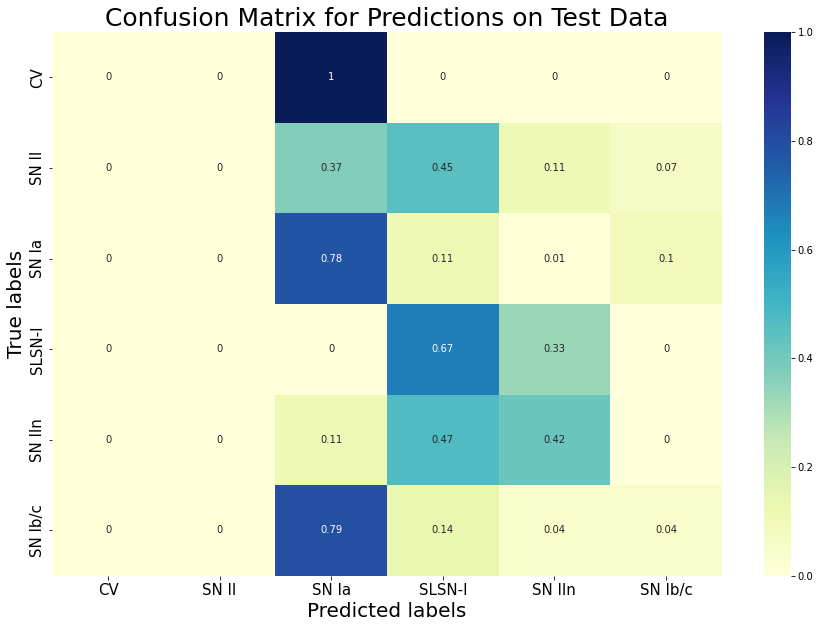

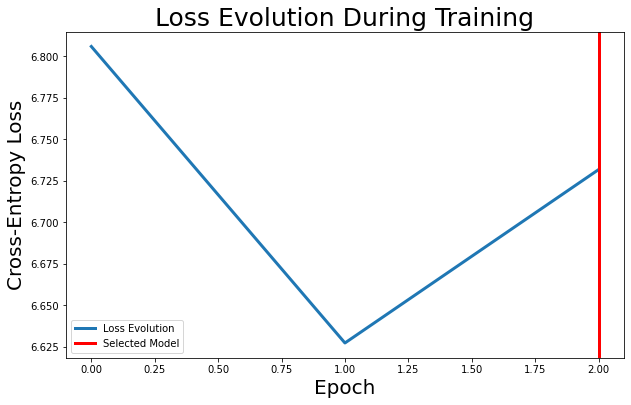

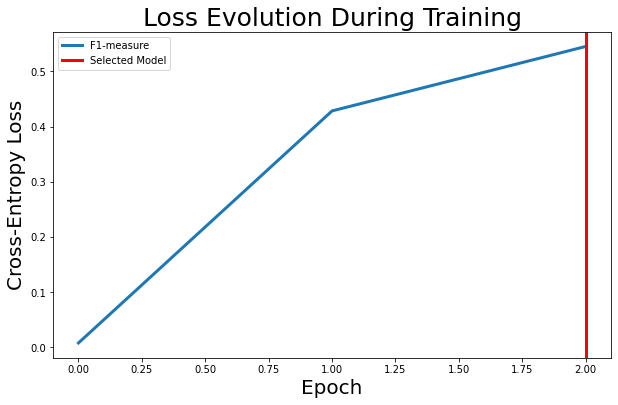

In [5]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 32
n_layers = 1
conv_out1 = 100
conv_out2 = 200
kernel1=9
kernel2=3

Net = sexy_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers, conv_out1=conv_out1, conv_out2=conv_out2, kernel1=kernel1, kernel2=kernel2)
print(Net)

# Initialisation
version_name = 'GRUconv_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 2

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### GRU64 + Convolution

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1
conv_out1 = 100
conv_out2 = 200
kernel1=9
kernel2=3

Net = sexy_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers, conv_out1=conv_out1, conv_out2=conv_out2, kernel1=kernel1, kernel2=kernel2)
print(Net)

# Initialisation
version_name = 'GRUconv_Pen_5_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Simple GRU32

simple_ENID(
  (GRU): GRU(2, 64, batch_first=True)
  (Dense): Linear(in_features=64, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 6.94592
Epoch: 5, loss: 6.25703
Epoch: 10, loss: 6.10453
Epoch: 15, loss: 5.89514
Epoch: 20, loss: 5.88836
Epoch: 25, loss: 5.76772
Epoch: 30, loss: 5.70479
Epoch: 35, loss: 5.80005
Epoch: 40, loss: 5.68490
Epoch: 45, loss: 5.69343
Epoch: 50, loss: 5.67013
Epoch: 55, loss: 5.70943
Epoch: 60, loss: 5.68282
Epoch: 65, loss: 5.55189
Epoch: 69, Nice, loss: 5.53396
Epoch: 70, loss: 5.49580
Epoch: 75, loss: 5.46483
Epoch: 80, loss: 5.76994
Epoch: 85, loss: 5.71025
Epoch: 90, loss: 5.82118
Epoch: 95, loss: 5.67495
Epoch: 100, loss: 6.00280
Epoch: 105, loss: 5.61349
Epoch: 110, loss: 5.62433
Epoch: 115, loss: 5.51806
Epoch: 120, loss: 5.44435
Epoch: 125, loss: 5.87419
Epoch: 130, loss: 5.82357
Epoch: 135, loss: 5.58073
Epoch: 140, loss: 5.51776
Epoch: 145, loss: 5.58893
Epoch: 150, loss: 5.68867
Epoch: 155, loss: 6.33265
Epoch: 160, loss:

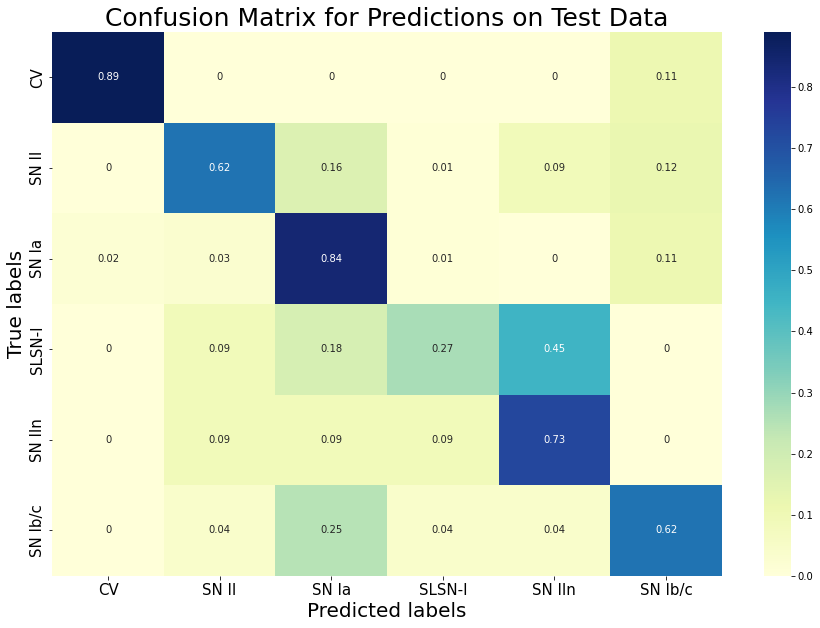

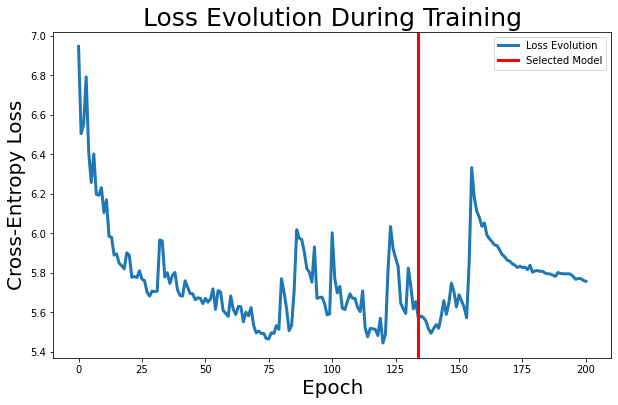

In [5]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 32
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Simple GRU64

simple_ENID(
  (GRU): GRU(2, 64, batch_first=True)
  (Dense): Linear(in_features=64, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 6.81796
Epoch: 5, loss: 6.79195
Epoch: 10, loss: 6.46577
Epoch: 15, loss: 6.37264
Epoch: 20, loss: 6.34292
Epoch: 25, loss: 6.32555
Epoch: 30, loss: 6.30411
Epoch: 35, loss: 6.29488
Epoch: 40, loss: 6.26969
Epoch: 45, loss: 6.23898
Epoch: 50, loss: 6.18868
Epoch: 55, loss: 6.07249
Epoch: 60, loss: 5.98674
Epoch: 65, loss: 5.96545
Epoch: 69, Nice, loss: 5.95055
Epoch: 70, loss: 5.95521
Epoch: 75, loss: 5.93635
Epoch: 80, loss: 5.92764
Epoch: 85, loss: 5.93305
Epoch: 90, loss: 5.91364
Epoch: 95, loss: 5.90523
Epoch: 100, loss: 5.89994
Epoch: 105, loss: 5.88885
Epoch: 110, loss: 5.89346
Epoch: 115, loss: 5.88199
Epoch: 120, loss: 5.86575
Epoch: 125, loss: 5.87192
Epoch: 130, loss: 5.85777
Epoch: 135, loss: 5.86667
Epoch: 140, loss: 5.84526
Epoch: 145, loss: 5.83484
Epoch: 150, loss: 5.82865
Epoch: 155, loss: 5.81486
Epoch: 160, loss:

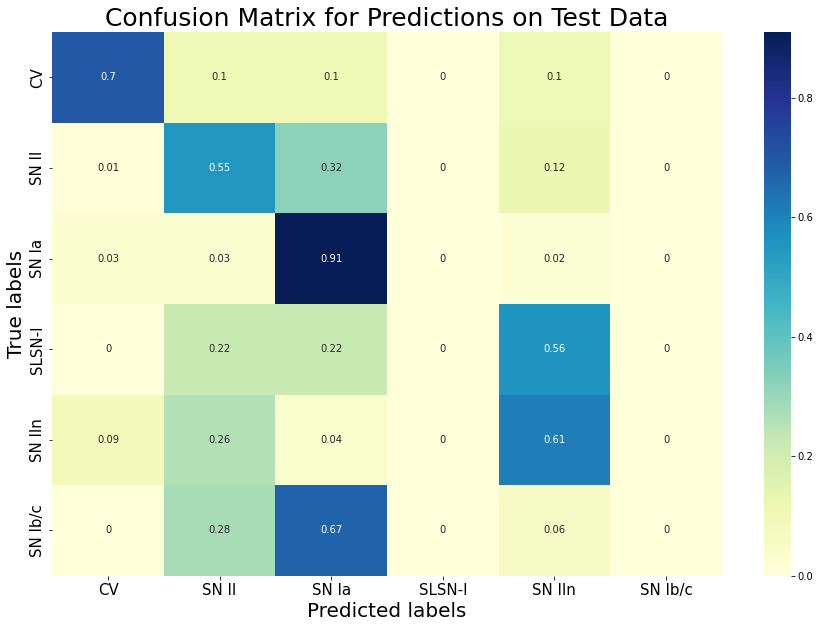

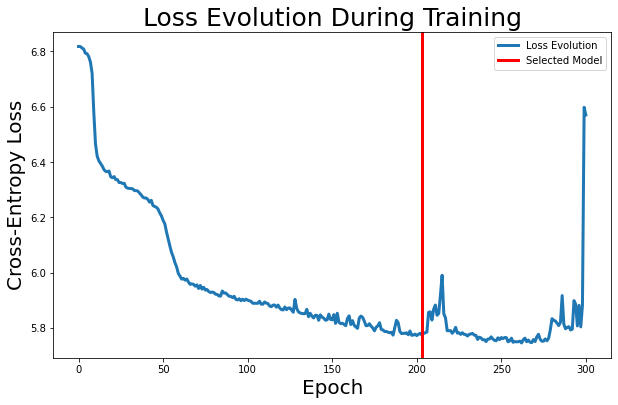

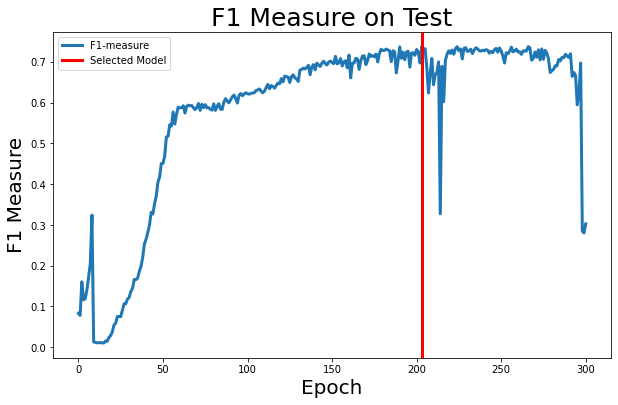

In [7]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_5_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Simple GRU128

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 128
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_5_HU128BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU32x32

rapid_ENID(
  (GRU1): GRU(2, 64, batch_first=True)
  (GRU2): GRU(64, 64, batch_first=True)
  (Dropout): Dropout(p=0.2, inplace=False)
  (Dense): Linear(in_features=64, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 7.11560
Epoch: 5, loss: 6.85706
Epoch: 10, loss: 6.44449
Epoch: 15, loss: 6.30135
Epoch: 20, loss: 6.23980
Epoch: 25, loss: 6.21011
Epoch: 30, loss: 6.08361
Epoch: 35, loss: 6.21428
Epoch: 40, loss: 6.23299
Epoch: 45, loss: 6.31288
Epoch: 50, loss: 6.77159
Epoch: 55, loss: 6.59810
Epoch: 60, loss: 6.38763
Epoch: 65, loss: 6.39806
Epoch: 69, Nice, loss: 6.50781
Epoch: 70, loss: 6.49982
Epoch: 75, loss: 6.42775
Epoch: 80, loss: 6.42506
Epoch: 85, loss: 6.33735
Epoch: 90, loss: 6.44014
Epoch: 95, loss: 6.40267
Epoch: 100, loss: 6.36129
Epoch: 105, loss: 6.34208
Epoch: 110, loss: 6.31955
Epoch: 115, loss: 6.32633
Epoch: 120, loss: 6.28346
Epoch: 125, loss: 6.30024
Epoch: 130, loss: 6.40137
Epoch: 135, loss: 6.29112
Epoch: 140, loss: 6.24272
Epoch: 145, 

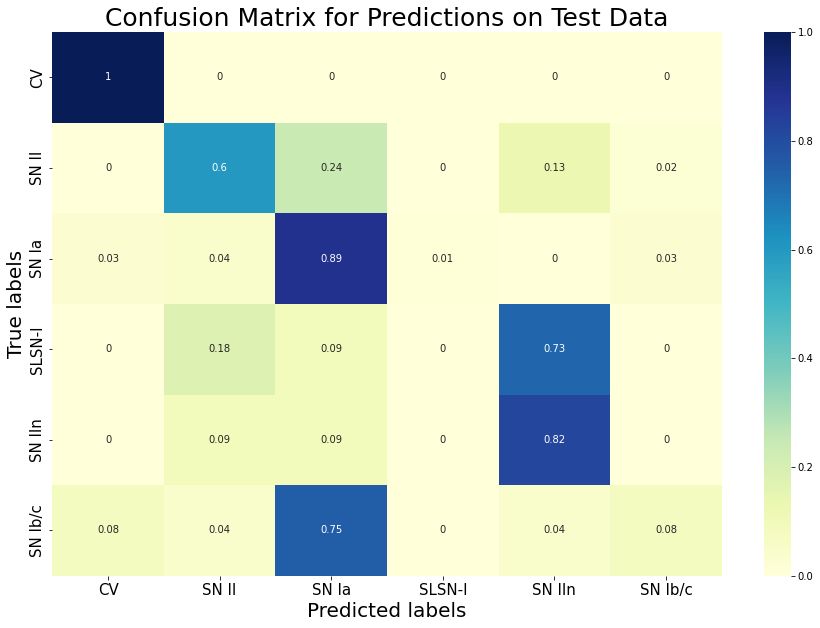

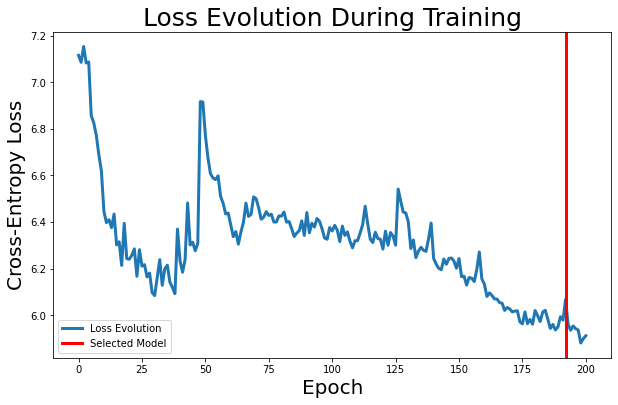

In [9]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 32
hidden_dim2 = 32
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU32x64

rapid_ENID(
  (GRU1): GRU(2, 64, batch_first=True)
  (GRU2): GRU(64, 128, batch_first=True)
  (Dropout): Dropout(p=0.2, inplace=False)
  (Dense): Linear(in_features=128, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 7.12522
Epoch: 5, loss: 6.59239
Epoch: 10, loss: 6.75912
Epoch: 15, loss: 6.74639
Epoch: 20, loss: 6.79384
Epoch: 25, loss: 6.75994
Epoch: 30, loss: 6.76228
Epoch: 35, loss: 6.72248
Epoch: 40, loss: 6.71405
Epoch: 45, loss: 6.73443
Epoch: 50, loss: 6.76065
Epoch: 55, loss: 6.60437
Epoch: 60, loss: 6.45814
Epoch: 65, loss: 6.39257
Epoch: 69, Nice, loss: 6.40871
Epoch: 70, loss: 6.35583
Epoch: 75, loss: 6.29989
Epoch: 80, loss: 6.29539
Epoch: 85, loss: 6.31140
Epoch: 90, loss: 6.27364
Epoch: 95, loss: 6.28653
Epoch: 100, loss: 6.28635
Epoch: 105, loss: 6.22568
Epoch: 110, loss: 6.25102
Epoch: 115, loss: 6.23662
Epoch: 120, loss: 6.25115
Epoch: 125, loss: 6.29817
Epoch: 130, loss: 6.31008
Epoch: 135, loss: 6.24680
Epoch: 140, loss: 6.26215
Epoch: 145

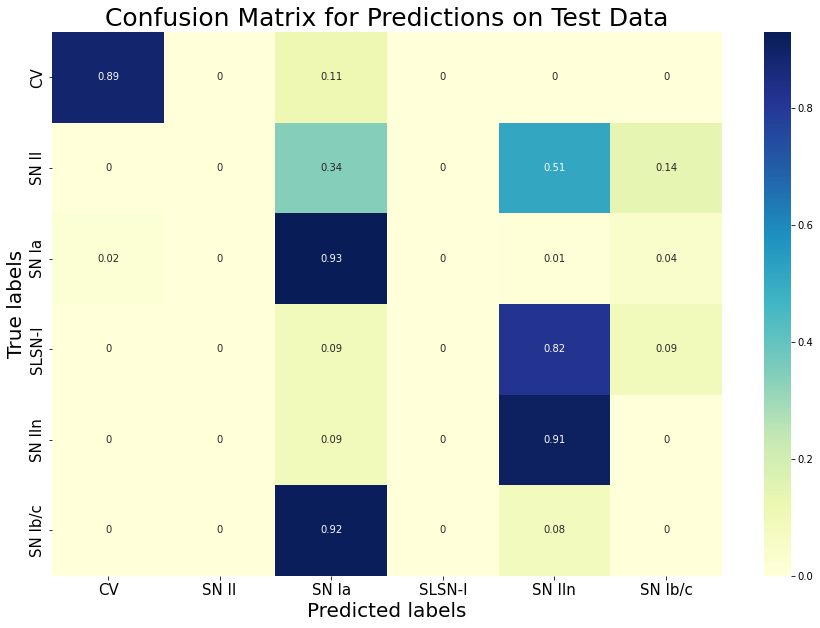

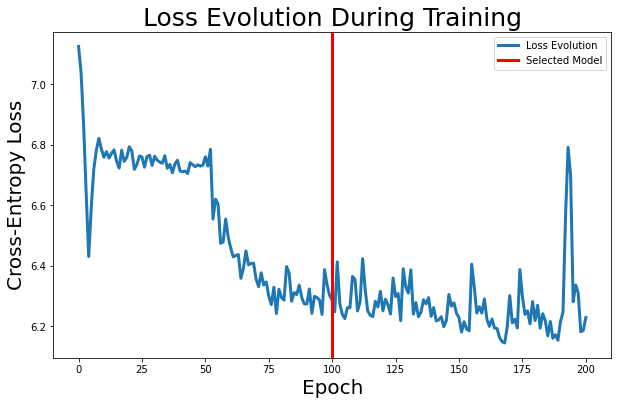

In [11]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 32
hidden_dim2 = 64
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU3264BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU64x32

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 64
hidden_dim2 = 32
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU3264BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU64x64

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 64
hidden_dim2 = 64
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Bi-directional GRU32

bi_ENID(
  (GRU): GRU(2, 32, batch_first=True, bidirectional=True)
  (Dense): Linear(in_features=64, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 6.89235
Epoch: 5, loss: 6.47245
Epoch: 10, loss: 6.31429
Epoch: 15, loss: 6.31410
Epoch: 20, loss: 6.25131
Epoch: 25, loss: 6.21533
Epoch: 30, loss: 6.27380
Epoch: 35, loss: 6.24107
Epoch: 40, loss: 6.23457
Epoch: 45, loss: 6.15885
Epoch: 50, loss: 6.09248
Epoch: 55, loss: 6.16750
Epoch: 60, loss: 6.08048
Epoch: 65, loss: 6.04954
Epoch: 69, Nice, loss: 6.01891
Epoch: 70, loss: 6.01839
Epoch: 75, loss: 5.97832
Epoch: 80, loss: 5.93492
Epoch: 85, loss: 5.95991
Epoch: 90, loss: 6.03872
Epoch: 95, loss: 5.94884
Epoch: 100, loss: 5.84485
Epoch: 105, loss: 5.91150
Epoch: 110, loss: 5.88006
Epoch: 115, loss: 5.92482
Epoch: 120, loss: 5.82360
Epoch: 125, loss: 5.82656
Epoch: 130, loss: 5.95897
Epoch: 135, loss: 5.86385
Epoch: 140, loss: 5.76842
Epoch: 145, loss: 6.00142
Epoch: 150, loss: 6.27214
Epoch: 155, loss: 6.07303
E

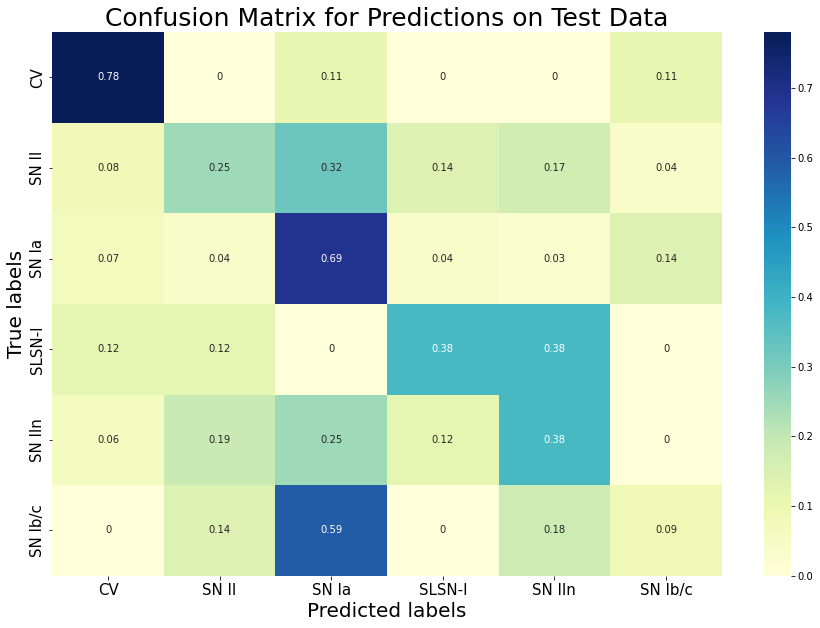

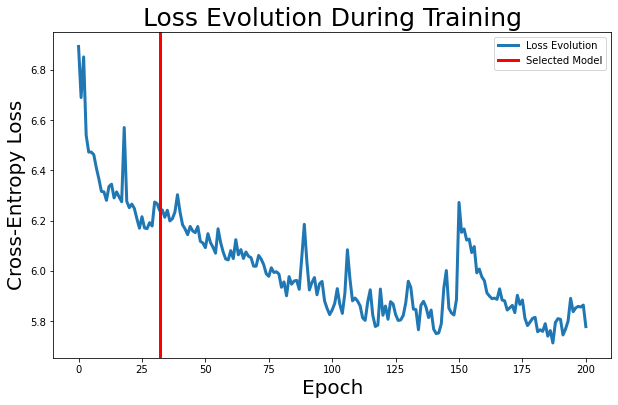

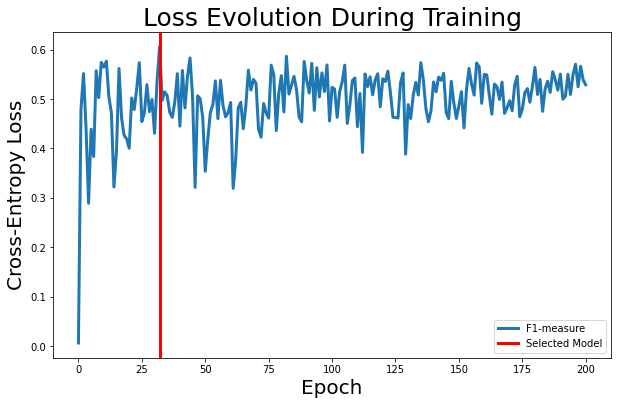

In [9]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 32
n_layers = 1

Net = bi_ENID(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRUbi_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Bi-directional GRU64

bi_ENID(
  (GRU): GRU(2, 64, batch_first=True, bidirectional=True)
  (Dense): Linear(in_features=128, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 6.96767
Epoch: 5, loss: 6.59506
Epoch: 10, loss: 6.35896
Epoch: 15, loss: 6.54534
Epoch: 20, loss: 6.47274
Epoch: 25, loss: 6.47673
Epoch: 30, loss: 6.44674
Epoch: 35, loss: 6.37256
Epoch: 40, loss: 6.40403
Epoch: 45, loss: 6.30025
Epoch: 50, loss: 6.34004
Epoch: 55, loss: 6.36096
Epoch: 60, loss: 6.29345
Epoch: 65, loss: 6.29569
Epoch: 69, Nice, loss: 6.24255
Epoch: 70, loss: 6.22725
Epoch: 75, loss: 6.19194
Epoch: 80, loss: 6.21649
Epoch: 85, loss: 6.33730
Epoch: 90, loss: 6.22253
Epoch: 95, loss: 6.20069
Epoch: 100, loss: 6.21035
Epoch: 105, loss: 6.20627
Epoch: 110, loss: 6.21705
Epoch: 115, loss: 6.17358
Epoch: 120, loss: 6.19566
Epoch: 125, loss: 6.32673
Epoch: 130, loss: 6.40337
Epoch: 135, loss: 6.37573
Epoch: 140, loss: 6.30781
Epoch: 145, loss: 6.38533
Epoch: 150, loss: 6.27367
Epoch: 155, loss: 6.23811


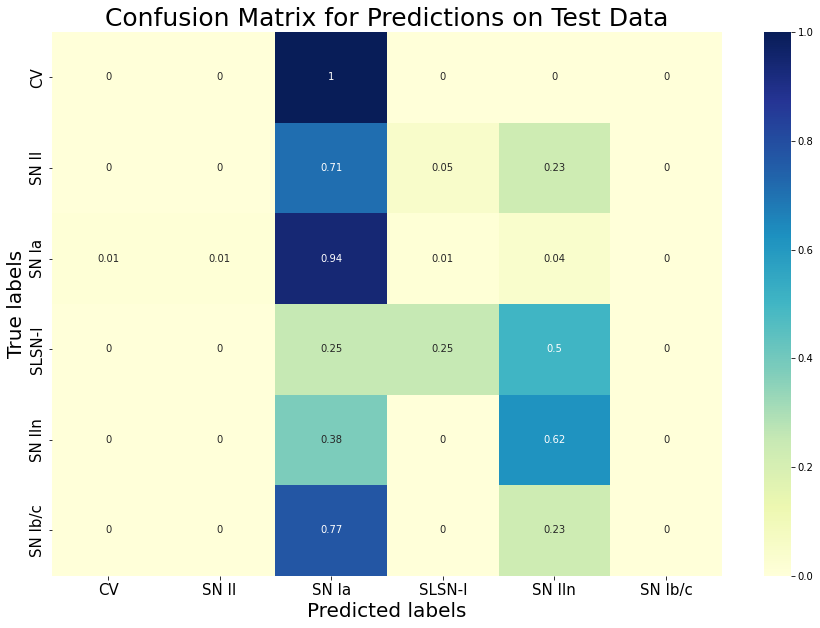

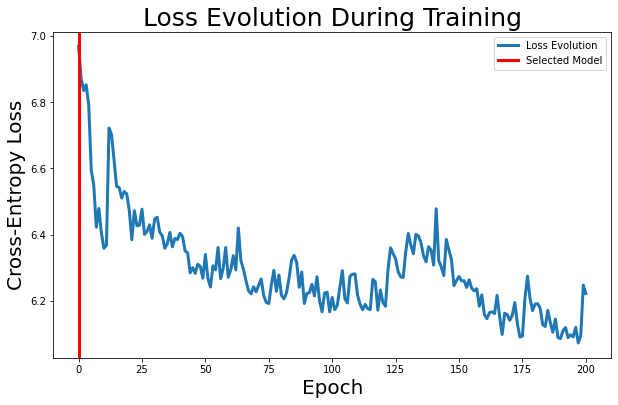

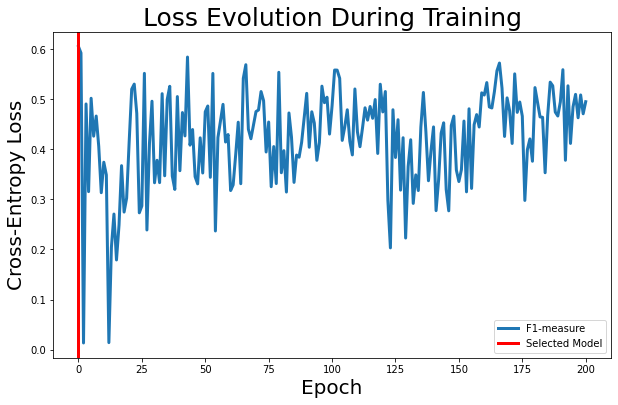

In [10]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1

Net = bi_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRUbi_Pen_5_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

## Binary Classification

In [3]:
# Standardise Data
#data = StandardScaler().fit_transform(data)
y = np.array([int(labels[i,1]) for i in range(labels.shape[0])])

# Filter out TDEs
#idx = np.where(y >= 0)[0]
idx_SNII = np.where(y == 1)[0]
idx_SNIa = np.where(y == 2)[0]
idx = np.concatenate([idx_SNII, idx_SNIa])

labels_ = labels[idx]
Y = torch.tensor(y[idx]) - 1
X = torch.permute(torch.tensor(data[idx]), [0,2,1])

# Check that the proportion of each class is roughly the same in the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
W = [1/count for count in np.unique(Y_train, return_counts=True)[1]]
W = W / min(W)
W = [int(element) for element in W]
W = [9, 1]

print('Unique Labels :', np.unique(Y_train, return_counts=True)[0])
print('Training Label Proportions : ', np.unique(Y_train, return_counts=True)[1])
print('Test Label Proportions : ', np.unique(Y_test, return_counts=True)[1])
print('Estimated Class Weights : ', W, '\n')

# One-Hot Encoding
Y = label_encoding(Y).float()

# Final partitioning of the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print('Training Data Dimensions :', X_train.shape)
print('Training Label Dimensions :', Y_train.shape, '\n')

print('Test Data Dimensions :', X_test.shape)
print('Test Label Dimensions :', Y_test.shape, '\n')

Unique Labels : [0 1]
Training Label Proportions :  [ 719 2667]
Test Label Proportions :  [ 73 304]
Estimated Class Weights :  [9, 1] 

Training Data Dimensions : torch.Size([3386, 200, 2])
Training Label Dimensions : torch.Size([3386, 2]) 

Test Data Dimensions : torch.Size([377, 200, 2])
Test Label Dimensions : torch.Size([377, 2]) 



In [4]:
class simple_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(simple_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=False) 
        self.Dense = nn.Linear(hidden_dim, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU(x)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_
    
class bi_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(bi_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True) 
        self.Dense = nn.Linear(2*hidden_dim, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU(x)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_
    
class rapid_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, n_layers):
        super(rapid_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU1 = nn.GRU(input_dim, hidden_dim1, n_layers, batch_first=True, bidirectional=False) 
        self.GRU2 = nn.GRU(hidden_dim1, hidden_dim2, n_layers, batch_first=True, bidirectional=False) 
        self.Dropout = nn.Dropout(p=0.2)
        self.Dense = nn.Linear(hidden_dim2, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU1(x)
        x_ = self.Dropout(x_)
        x_, h_ = self.GRU2(x_)
        x_ = self.Dropout(x_)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_

class sexy_ENID(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, conv_out1, conv_out2, kernel1, kernel2):
        super(sexy_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.channels1 = conv_out1
        self.channels2 = conv_out2
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.conv1_out = 200 - 2*(self.kernel1 - 1)
        self.conv2_out = self.conv1_out - 2 * (self.kernel2 - 1)
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=False) 
        
        self.Conv1 = nn.Conv1d(in_channels=2, out_channels=conv_out1, kernel_size=kernel1)
        self.Conv2 = nn.Conv1d(in_channels=conv_out1, out_channels=conv_out2, kernel_size=kernel2)
        self.Dense1_conv = nn.Linear(190, hidden_dim)
        #self.Dense2_conv = nn.Linear(out1_conv, out2_conv)
        self.relu = nn.ReLU()
        
        #self.DenseGRU = nn.Linear(hidden_dim, out_GRU)
        
        self.Dense = nn.Linear(2*hidden_dim, output_dim)
        self.Dropout = nn.Dropout(p=0.2)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        x_GRU, h_ = self.GRU(x)
        x_GRU = self.Dropout(x_GRU)
        #x_GRU = self.Dense(x_GRU[:,-1])
        
        x_ = torch.permute(x, (0,2,1))
        x_conv = self.Conv1(x_)
        x_conv = self.relu(x_conv)
        x_conv = self.Conv2(x_conv)
        x_conv = self.relu(x_conv)
        x_conv = self.Dropout(x_conv)
        x_conv = self.Dense1_conv(x_conv)
        x_conv = self.Dropout(x_conv)
        
        x_ENID = torch.cat((x_GRU, x_conv), dim=2)
        
        x_ENID = self.Dense(x_ENID[:,-1])
        x_ENID = self.predict(x_ENID)
        
        return x_ENID

simple_ENID(
  (GRU): GRU(2, 32, batch_first=True)
  (Dense): Linear(in_features=32, out_features=2, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 1.45527
Epoch: 5, loss: 1.33957
Epoch: 10, loss: 1.28517
Epoch: 15, loss: 1.31786
Epoch: 20, loss: 1.20164
Epoch: 25, loss: 1.17642
Epoch: 30, loss: 1.16531
Epoch: 35, loss: 1.27538
Epoch: 40, loss: 1.13761
Epoch: 45, loss: 1.13315
Epoch: 50, loss: 1.13587
Epoch: 55, loss: 1.11644
Epoch: 60, loss: 1.10204
Epoch: 65, loss: 1.08475
Epoch: 69, Nice, loss: 1.09731
Epoch: 70, loss: 1.10443
Epoch: 75, loss: 1.07491
Epoch: 80, loss: 1.06478
Epoch: 85, loss: 1.11869
Epoch: 90, loss: 1.06016
Epoch: 95, loss: 1.05826
Epoch: 100, loss: 1.02705
Epoch: 105, loss: 1.03856
Epoch: 110, loss: 1.11626
Epoch: 115, loss: 1.07437
Epoch: 120, loss: 1.25106
Epoch: 125, loss: 1.19286
Epoch: 130, loss: 1.20478
Epoch: 135, loss: 1.25932
Epoch: 140, loss: 1.46381
Epoch: 145, loss: 1.35214
Epoch: 150, loss: 1.33445
Epoch: 155, loss: 1.31329
Epoch: 160, loss:

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (6).

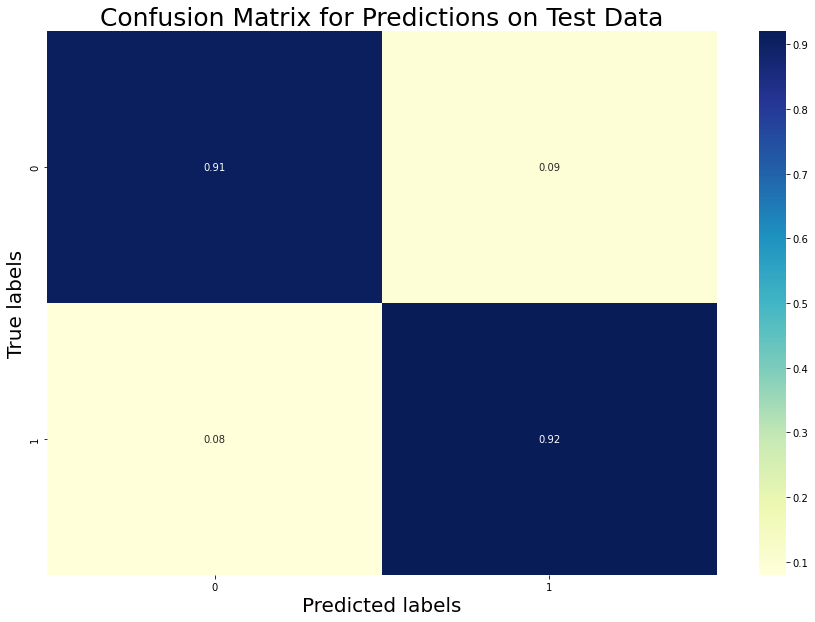

In [5]:
# Model Building
input_dim = X_train.shape[2]
num_classes = 2
hidden_dim = 32
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_Binary_HU64BZ256EP200IT02'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

## Some Lightcurve Visualisation

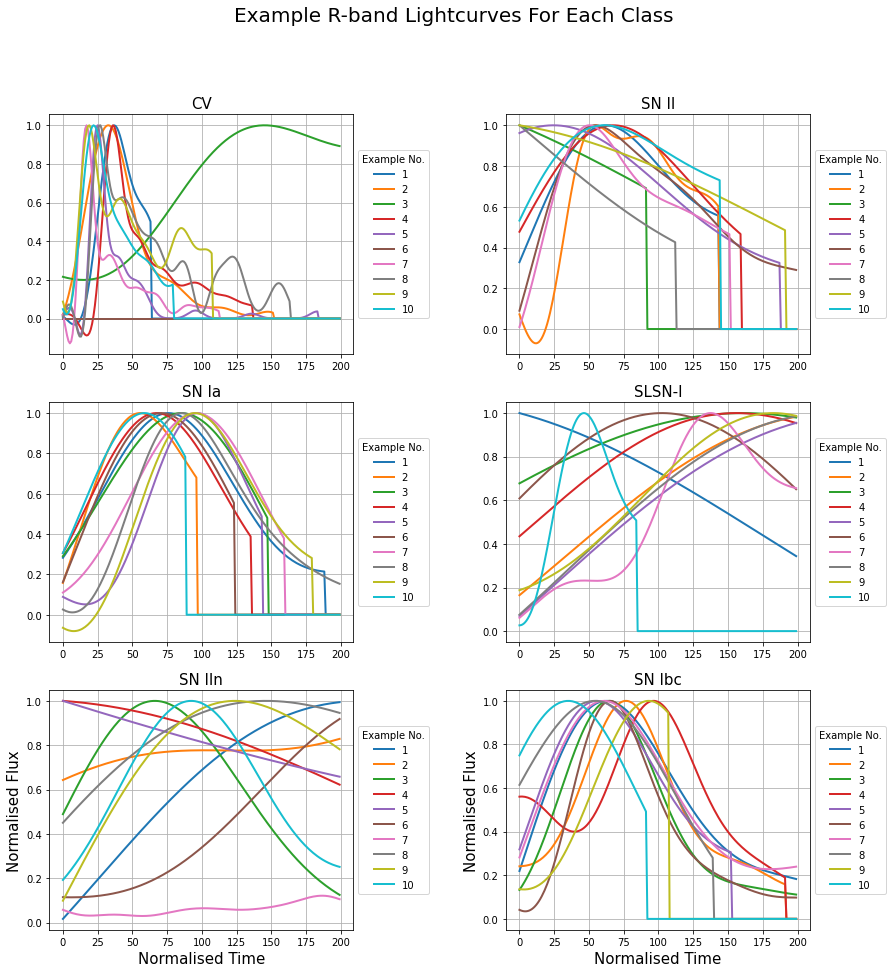

In [4]:
sublabels = [int(label[1]) for label in labels]
uniques = np.unique(sublabels)
fig, axs = plt.subplots(3, 2,figsize=(15,15))
axs = axs.flatten()

for i in uniques[1:len(uniques)]:
    idx = np.where(sublabels == i)[0]
    for j in range(len(idx[0:10])):
        axs[i].plot(data[idx[j],0,:], linewidth=2, label=str(j+1))
        #axs[i].plot(data[idx[j],1,:], linewidth=2)
    axs[i].set_title(labels[idx[0]][0], fontsize=15)
    axs[i].grid()
    
    # Shrink current axis by 20%
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    axs[i].legend(loc='center left', title="Example No.", bbox_to_anchor=(1, 0.5))

axs[4].set_ylabel('Normalised Flux', fontsize=15)
axs[4].set_xlabel('Normalised Time', fontsize=15)
axs[5].set_ylabel('Normalised Flux', fontsize=15)
axs[5].set_xlabel('Normalised Time', fontsize=15)
fig.suptitle('Example R-band Lightcurves For Each Class', fontsize=20)
fig.savefig('Data/LC_GEORGE_Multiple.png')

440 3956


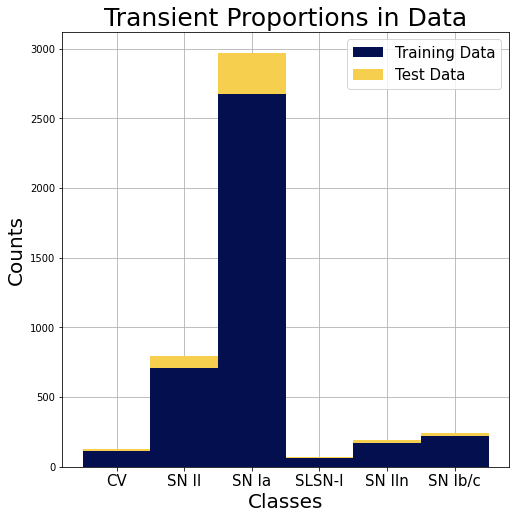

In [5]:
count_test = []
for i in range(Y_test.numpy().shape[0]):
    count_test.append(np.argmax(Y_test.numpy()[i,:]))

count_train = []
for i in range(Y_train.numpy().shape[0]):
    count_train.append(np.argmax(Y_train.numpy()[i,:]))

print(len(count_test), len(count_train))

plt.figure(figsize=(8,8))
bins = np.arange(7) - 0.5
plt.grid(zorder=0)
test1, test2, test3 = plt.hist([count_train, count_test], bins, stacked=True, color=[(3/256, 15/256, 79/256), (246/256, 208/256, 77/256)], label=['Training Data', 'Test Data'], zorder=2)
#plt.yscale('log')
plt.xticks(np.arange(6), ['CV', 'SN II', 'SN Ia', 'SLSN-I', 'SN IIn', 'SN Ib/c'], fontsize=15)
plt.title('Transient Proportions in Data', fontsize=25)
plt.xlabel('Classes', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.legend(fontsize=15)
#plt.savefig('Data/ClassImbalance.png')

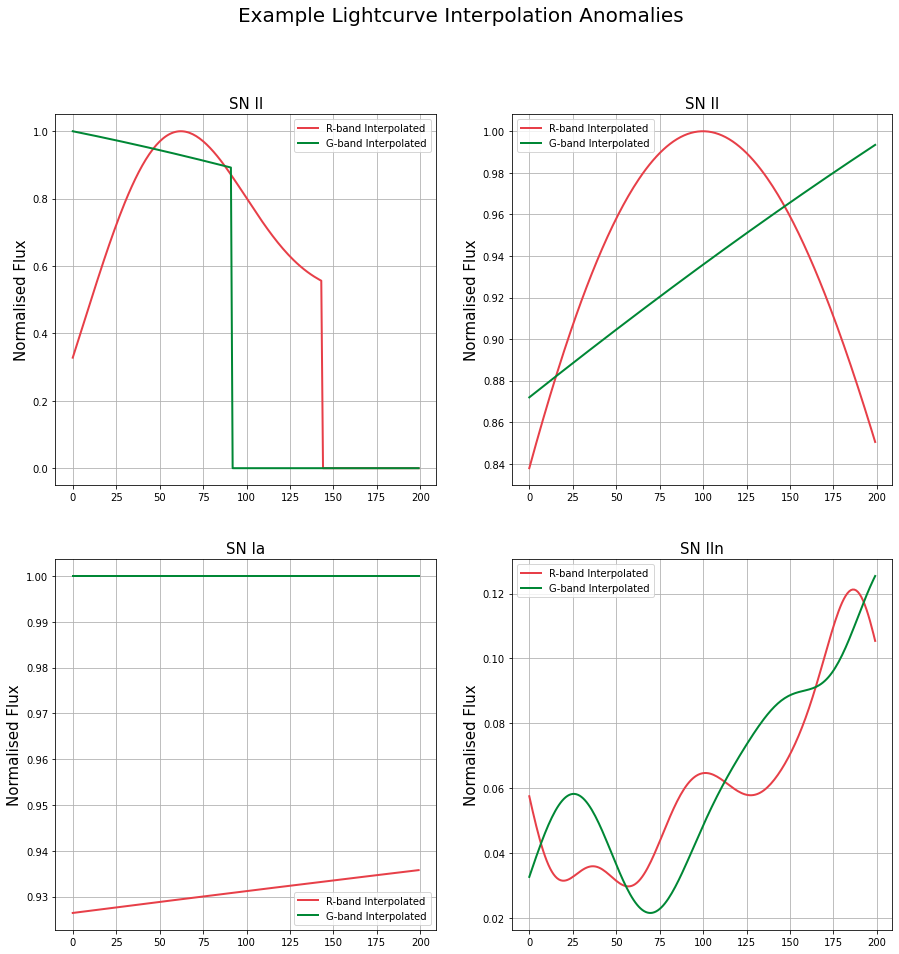

In [6]:
#index1 = 157
#index2 = 142
#index3 = 529
#index4 = 170
#index5 = 519
#index6 = 321
index1 = 1
index2 = 119
index3 = 166
index4 = 165

fig, axs = plt.subplots(2, 2,figsize=(15,15))

axs[0,0].plot(data[index1,0,:], linewidth=2, c=(232/256, 63/256, 72/256), label='R-band Interpolated')
axs[0,0].plot(data[index1,1,:], linewidth=2, c=(0/256, 136/256, 53/256), label='G-band Interpolated')
axs[0,0].set_ylabel('Normalised Flux', fontsize=15)
axs[0,0].set_title(labels[index1][0], fontsize=15)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(data[index2,0,:], linewidth=2, c=(232/256, 63/256, 72/256), label='R-band Interpolated')
axs[0,1].plot(data[index2,1,:], linewidth=2, c=(0/256, 136/256, 53/256), label='G-band Interpolated')
axs[0,1].set_ylabel('Normalised Flux', fontsize=15)
axs[0,1].set_title(labels[index2][0], fontsize=15)
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(data[index3,0,:], linewidth=2, c=(232/256, 63/256, 72/256), label='R-band Interpolated')
axs[1,0].plot(data[index3,1,:], linewidth=2, c=(0/256, 136/256, 53/256), label='G-band Interpolated')
axs[1,0].set_ylabel('Normalised Flux', fontsize=15)
axs[1,0].set_title(labels[index3][0], fontsize=15)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(data[index4,0,:], linewidth=2, c=(232/256, 63/256, 72/256), label='R-band Interpolated')
axs[1,1].plot(data[index4,1,:], linewidth=2, c=(0/256, 136/256, 53/256), label='G-band Interpolated')
axs[1,1].set_ylabel('Normalised Flux', fontsize=15)
axs[1,1].set_title(labels[index4][0], fontsize=15)
axs[1,1].grid()
axs[1,1].legend()

#axs[2,0].plot(data[index5,0,:], linewidth=2, c=(232/256, 63/256, 72/256), label='R-band Interpolated')
#axs[2,0].plot(data[index5,1,:], linewidth=2, c=(0/256, 136/256, 53/256), label='G-band Interpolated')
#axs[2,0].set_xlabel('Normalised Time', fontsize=15)
#axs[2,0].set_ylabel('Normalised Flux', fontsize=15)
#axs[2,0].set_title(labels[index5][0], fontsize=15)
#axs[2,0].grid()
#axs[2,0].legend()

#axs[2,1].plot(data[index6,0,:], linewidth=2, c=(232/256, 63/256, 72/256), label='R-band Interpolated')
#axs[2,1].plot(data[index6,1,:], linewidth=2, c=(0/256, 136/256, 53/256), label='G-band Interpolated')
#axs[2,1].set_xlabel('Normalised Time', fontsize=15)
#axs[2,1].set_ylabel('Normalised Flux', fontsize=15)
#axs[2,1].set_title('SN Ib/c', fontsize=15)
#axs[2,1].grid()
#axs[2,1].legend()

fig.suptitle('Example Lightcurve Interpolation Anomalies', fontsize=20)
fig.savefig('Data/LC_GEORGE_Failed.png')